# Dalhi Daily Climate Time Series Project
### Timeseries projects using the deep learning approach

Author: Geovanna Santos Nobre de Oliveira

The dataset:

**Link:** [Daily Climate Time Series Data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download)

**Content:** The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure.

**Acknowledgements:** This dataset has been collected from Weather Undergroud API. Dataset ownership and credit goes to them.

## 2. Deep Learning Approach: LSTM

The *"1. Statistical Approach"* is in the previous notebook.

### 2.1. Importing libraries and loading data

In [31]:
import datetime 

import numpy as np
import pandas as pd
import seaborn as sns 
import tensorflow as tf 
import matplotlib.pyplot as plt

from math import sqrt

from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.grid'] = False

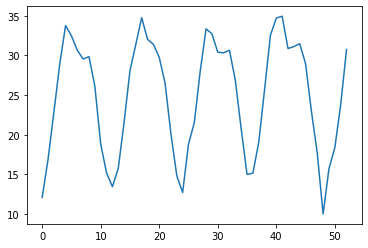

In [3]:
df_train_raw = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
df_train_raw.index.freq = "D"

df_test_raw = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
df_test_raw.index.freq = "D"

# Adjusting to monthly means
df_train = df_train_raw[["meantemp"]].resample("M").mean()
df_test = df_test_raw[["meantemp"]].resample("M").mean()

plt.plot(np.append(df_train, df_test))

### 2.2. Preprocessing data

In [4]:
# Scale data
scaler = StandardScaler()

scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

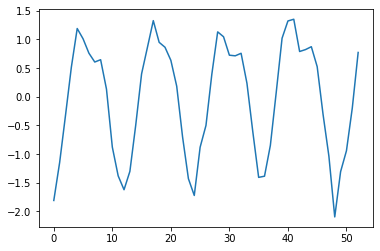

In [8]:
plt.plot(np.append(df_train_scaled, df_test_scaled))

### 2.3. Modeling

In [11]:
n_input = 9
n_features = 1

generator = TimeseriesGenerator(df_train_scaled, df_train_scaled, length=n_input, batch_size=1)

In [16]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True, activation='relu', input_shape=(n_input, n_features)),
    LSTM(32, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 9, 32)             4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 25)                825       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,523
Trainable params: 13,523
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = lstm_model.fit(generator, epochs=50)

Epoch 1/50
40/40 [==============================] - 2s 4ms/step - loss: 0.9662 - mean_absolute_error: 0.8676
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 0.4594 - mean_absolute_error: 0.5728
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 0.2386 - mean_absolute_error: 0.4071
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.2326 - mean_absolute_error: 0.3705
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 0.1943 - mean_absolute_error: 0.3713
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 0.1847 - mean_absolute_error: 0.3379
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.1483 - mean_absolute_error: 0.3068
Epoch 8/50
40/40 [==============================] - 0s 4ms/step - loss: 0.1771 - mean_absolute_error: 0.3339
Epoch 9/50
40/40 [==============================] - 0s 4ms/step - loss: 0.1916 - mean_absolute_error: 0.3491
Epoch 10/50
40/40 [

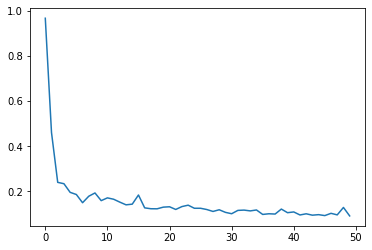

In [19]:
loss_per_epoch = lstm_model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [21]:
predictions_scaled = []
first_eval_batch = df_train_scaled[-n_input:]

current_batch = first_eval_batch.reshape((1, n_input, n_features))
n_months = 12

for i in range(n_months):
    current_pred = lstm_model.predict(current_batch)[0]
    
    predictions_scaled.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
predictions = scaler.inverse_transform(predictions_scaled)

1/1 [==============================] - 0s 14ms/step


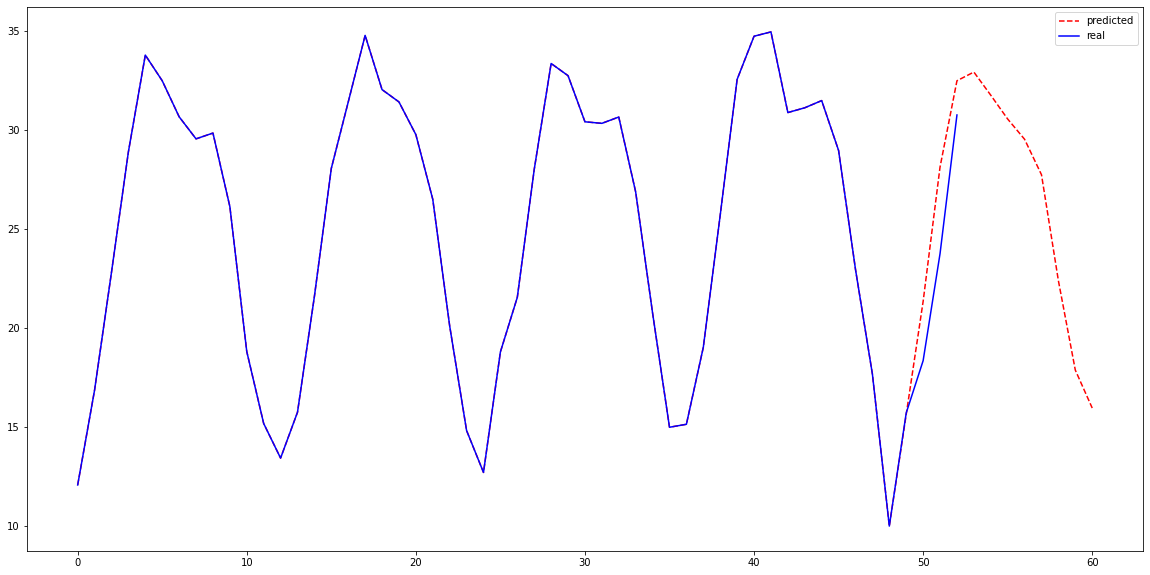

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(np.append(df_train, predictions), 'k--', color='red')
ax.plot(np.append(df_train,df_test), color="blue")

plt.legend(['predicted', 'real'])

In [32]:
rmse = sqrt(mean_squared_error(df_test, predictions[:len(df_test)]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.787


We can see that we got a RMSE equal to 2.787, better than the SARIMA model we did previous, which had a RMSE equal to 4.062. We can also test different models to see how that alters the RMSE.